In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
psi4.core.set_output_file('output.dat', False)
import time
import json
import matplotlib.pyplot as plt

We are going to read the energy eigenvalues and dipole matrix elements from .npy files.  We will also still create an instance of the PFHamiltonianGenerator class so we can use its build_pcqed_pf_hamiltonian() method, but it is not really important what details we use to instantiate this class... so we will use LiH in a minimal basis since this is a fast way to instantiate the class!

In [2]:
# read data from .npy files for formaldehyde casci(8,8) calculations

# !!! Change this to the correct path on your computer!
npy_folder = "/Users/rmandern/code/SCQED-PCQED/Formaldehyde/"

# these file names should still be good
E_npy_file = npy_folder + "CH2O_ccpVDZ_CASCI_88_1000_dipole_allowed_E_Array.npy"
Mu_npy_file = npy_folder + "CH2O_ccpVDZ_CASCI_88_1000_dipole_allowed_Mu_Array.npy"

# store energy eigenvalues in E_array
E_array = np.load(E_npy_file)
# store dipole matrix elements in Mu_array
Mu_array = np.load(Mu_npy_file)

# print their shape so we know how many elements we have
print(np.shape(E_array))
print(np.shape(Mu_array))

# setup basic arguments to create an instance of the PFHamiltonianGenerator class
mol_str = """
Li
H 1 1.8
symmetry c1
"""

options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
}


cavity_free_dict = {
    'omega_value' : 0.0,
    'lambda_vector' : np.array([0, 0, 0.0]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, 
}

# create the instance of our PFHamiltonianGenerator class
instance = PFHamiltonianGenerator(mol_str, options_dict, cavity_free_dict)

(1000,)
(1000, 1000, 3)

Start SCF iterations:

Canonical RHF One-electron energy = -12.2195250859903002
CQED-RHF One-electron energy      = -12.2195250859903002
Nuclear repulsion energy          = 0.8819620177833333
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8500186970978660   dE = -7.85002E+00   dRMS = 4.96348E-15
SCF Iteration   2: Energy = -7.8500186970978589   dE =  7.10543E-15   dRMS = 1.63539E-15
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.85001870 hartree
Psi4  SCF energy: -7.85001870 hartree
 Completed QED-RHF in 0.23051905632019043 seconds
 Completed 1HSO Build in 6.508827209472656e-05 seconds
 Completed ERI Build in 0.0012009143829345703 seconds 
 Completed 2D build in 0.00011277198791503906 seconds
 Completed 1G build in 1.621246337890625e-05 seconds
 Completed the Dipole Matrix Build in 3.886222839355469e-05 seconds
 Completed determinant list in 0.0004532337188720703 seconds 
 Completed constant offset mat

In [3]:
# open json file
f = open("CH2O_CO_r_1.3_casci_cc-pVDZ_n_act_els_8_n_act_orbs_8_dipole_allowed.json")
data = json.load(f)
# print(data)

In [4]:
# get the array of lambda values from the json file
lambdas = data["model"]["lambda_vector"]
# print(lambdas)
lambdas_val = np.array(lambdas)
print(lambdas_val)

# determine how many lambda values will be in the scan
N_l = len(lambdas)
print(N_l)
print(np.shape(lambdas))


[[0.    0.    0.   ]
 [0.    0.    0.005]
 [0.    0.    0.01 ]
 [0.    0.    0.015]
 [0.    0.    0.02 ]
 [0.    0.    0.025]
 [0.    0.    0.03 ]
 [0.    0.    0.035]
 [0.    0.    0.04 ]
 [0.    0.    0.045]
 [0.    0.    0.05 ]]
11
(11, 3)


In [5]:
fast_start = time.time()
# instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lambda_vector, E_array, Mu_array)
fast_end = time.time()
print(F"Fast build took {fast_end-fast_start} seconds")

Fast build took 5.078315734863281e-05 seconds


In [6]:

lambda_val = np.array(lambdas)

N_el = 2
N_ph = 2
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_22 = np.zeros((N_l, N_el * N_ph))
# loop over values of lambda, build Hamiltonian, capture eigenvalues
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_22[ctr, :] = instance.PCQED_eigs
    ctr += 1

# E_pcqed_52 = instance.PCQED_eigs

fast_end = time.time()
print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_22))
E_pcqed_22_array = np.array(_pcqed_22)
E_pcqed_22_list = E_pcqed_22_array.tolist()


Fast build took 0.0027081966400146484 seconds
(11, 4)


In [7]:
# n_ph 1 to 10 and nel 100 gap of 50 start from 2 and see the visible differences. 

In [8]:
# data_122 = data

# data_122["model"]["number_of_electronic_states"] = 12
# data_122["model"]["number_of_photonic_states"] = 2
# # store your list of eigenvalues for each lambda to the dictionary
# data_122["expected_result"] = E_pcqed_122_list
# # print(data_122["expected_result"])
# file_name = "CH2O_CO_r_1.3_pcqed_122.json"
# json_object = json.dumps(data_122["repo"], indent=4)
# with open(file_name, "w") as outfile:
#     outfile.write(json_object)
# keys_list = list(data_122.keys())
# print(keys_list)

In [9]:
data_22 = data

data_22["model"]["number_of_electronic_states"] = 2
data_22["model"]["number_of_photonic_states"] = 2
# keys_list = list(data_122.keys())
# print(keys_list)

# store your list of eigenvalues for each lambda to the dictionary
# data_122["expected_result"] = E_pcqed_122_list
# E_pcqed_122 = np.zeros((N_l, N_el * N_ph))
# print(len(E_pcqed_52[:,0]))
# loop over the different lambda values
#print(np.shape(E_pcqed_122[0, :]))
#energies = []
#for i in range(len(E_pcqed_122[:,0])):
#    sub_energies = []
#    for j in range(len(E_pcqed_122[:,0])):
#        sub_energies.append(E_pcqed_122[i,j])
#        E_pcqed_122[0, :] = _pcqed_122[:, np.newaxix]
#    energies.append(sub_energies)
    
# E_pcqed_52[0, :] = np.copy(instance.PCQED_eigs)
# print(energies)
data_22["return_result"] = E_pcqed_22_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_22.json"
json_object = json.dumps(data_22, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)


In [10]:
print(lambda_val[:,2])
_pcqed_22[:,2]

[0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05 ]


array([-113.55667049, -113.55666908, -113.55666484, -113.55665776,
       -113.55664783, -113.55663502, -113.55661931, -113.55660065,
       -113.55657901, -113.55655434, -113.55652657])

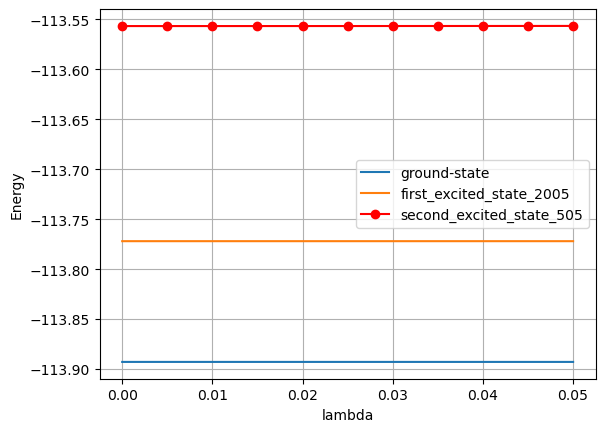

In [11]:
plt.plot(lambda_val[:,2], _pcqed_22[:,0], label="ground-state")
plt.plot(lambda_val[:,2],_pcqed_22[:,1], label='first_excited_state_2005')
plt.plot(lambda_val[:,2],_pcqed_22[:,2],'ro-', label='second_excited_state_505')
# plt.plot(lambda_val[:,2],_pcqed_22[:,0],'b', label='g_state_42')
# plt.plot(lambda_val[:,2],_pcqed_22[:,0],'y', label='g_state_5010')

plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.556, -113.50)
plt.grid()
plt.legend()

In [12]:
N_el = 12
N_ph = 2
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_122 = np.zeros((N_l, N_el * N_ph))
# loop over values of lambda, build Hamiltonian, capture eigenvalues
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_122[ctr, :] = instance.PCQED_eigs
    ctr += 1

# E_pcqed_52 = instance.PCQED_eigs

fast_end = time.time()
print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_122))
E_pcqed_122_array = np.array(_pcqed_122)
E_pcqed_122_list = E_pcqed_122_array.tolist()


Fast build took 0.004420757293701172 seconds
(11, 24)


In [13]:
data_122 = data

data_122["model"]["number_of_electronic_states"] = 12
data_122["model"]["number_of_photonic_states"] = 2
data_122["return_result"] = E_pcqed_122_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_122.json"
json_object = json.dumps(data_122, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)
    

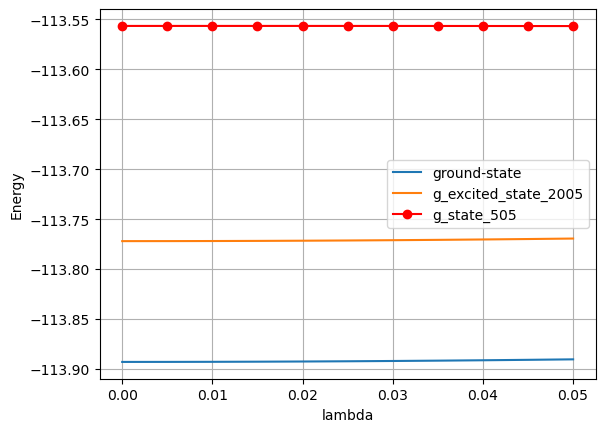

In [14]:
plt.plot(lambda_val[:,2], _pcqed_122[:,0], label="ground-state")
plt.plot(lambda_val[:,2],_pcqed_122[:,1], label='g_excited_state_2005')
plt.plot(lambda_val[:,2],_pcqed_122[:,2],'ro-', label='g_state_505')
# plt.plot(lambda_val[:,2],_pcqed_22[:,0],'b', label='g_state_42')
# plt.plot(lambda_val[:,2],_pcqed_22[:,0],'y', label='g_state_5010')

plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.556, -113.50)
plt.grid()
plt.legend()

In [15]:
N_el = 30
N_ph = 2
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_302 = np.zeros((N_l, N_el * N_ph))
# loop over values of lambda, build Hamiltonian, capture eigenvalues
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_302[ctr, :] = instance.PCQED_eigs
    ctr += 1

# E_pcqed_52 = instance.PCQED_eigs

fast_end = time.time()
print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_302))
E_pcqed_302_array = np.array(_pcqed_302)
E_pcqed_302_list = E_pcqed_302_array.tolist()


Fast build took 0.012763261795043945 seconds
(11, 60)


In [16]:
data_302 = data

data_302["model"]["number_of_electronic_states"] = 30
data_302["model"]["number_of_photonic_states"] = 2
data_302["return_result"] = E_pcqed_302_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_302.json"
json_object = json.dumps(data_302, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)
    

In [17]:
plt.plot(lambda_val[:,2], _pcqed_502[:,0], label="ground-state")
plt.plot(lambda_val[:,2],_pcqed_502[:,1], label='1st_excited_state_2005')
plt.plot(lambda_val[:,2],_pcqed_502[:,2],'ro-', label='2nd')
plt.plot(lambda_val[:,2],_pcqed_502[:,3],'b', label='3rd')
plt.plot(lambda_val[:,2],_pcqed_502[:,4],'y', label='4th')
# plt.plot(lambda_val[:,2],_pcqed_502[:,2],'ro-', label='g_state_505')

plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.556, -113.50)
plt.grid()
plt.legend()

NameError: name '_pcqed_502' is not defined

Fast build took 0.028338193893432617 seconds
(11, 150)


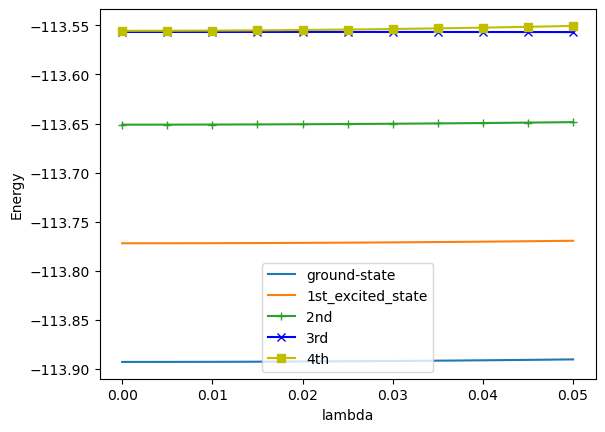

In [19]:
N_el = 15
N_ph = 10
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_1510 = np.zeros((N_l, N_el * N_ph))
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_1510[ctr, :] = instance.PCQED_eigs
    ctr += 1
fast_end = time.time()

print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_1510))

E_pcqed_1510_array = np.array(_pcqed_1510)
E_pcqed_1510_list = E_pcqed_1510_array.tolist()
data_1510 = data

data_1510["model"]["number_of_electronic_states"] = 15
data_1510["model"]["number_of_photonic_states"] = 10
data_1510["return_result"] = E_pcqed_1510_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_1510.json"
json_object = json.dumps(data_1510, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)
    
plt.plot(lambda_val[:,2], _pcqed_1510[:,0], label="ground-state")
plt.plot(lambda_val[:,2],_pcqed_1510[:,1], label='1st_excited_state')
plt.plot(lambda_val[:,2],_pcqed_1510[:,2],marker='+', label='2nd')
plt.plot(lambda_val[:,2],_pcqed_1510[:,3],'b',marker='x', label='3rd')
plt.plot(lambda_val[:,2],_pcqed_1510[:,4],'y',marker='s', label='4th')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.90, -113.85)
# plt.grid()
plt.legend()

Fast build took 0.3387308120727539 seconds
(11, 500)


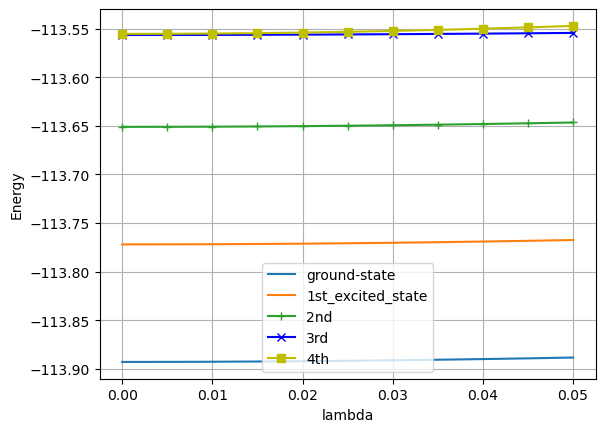

In [20]:
N_el = 100
N_ph = 5
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_1005 = np.zeros((N_l, N_el * N_ph))
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_1005[ctr, :] = instance.PCQED_eigs
    ctr += 1
fast_end = time.time()

print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_1005))

E_pcqed_1005_array = np.array(_pcqed_1005)
E_pcqed_1005_list = E_pcqed_1005_array.tolist()
data_1005 = data

data_1005["model"]["number_of_electronic_states"] = 100
data_1005["model"]["number_of_photonic_states"] = 5
data_1005["return_result"] = E_pcqed_1005_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_1005.json"
json_object = json.dumps(data_1005, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)
    
plt.plot(lambda_val[:,2], _pcqed_1005[:,0], label="ground-state")
plt.plot(lambda_val[:,2],_pcqed_1005[:,1], label='1st_excited_state')
plt.plot(lambda_val[:,2],_pcqed_1005[:,2],marker='+', label='2nd')
plt.plot(lambda_val[:,2],_pcqed_1005[:,3],'b',marker='x', label='3rd')
plt.plot(lambda_val[:,2],_pcqed_1005[:,4],'y',marker='s', label='4th')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.90, -113.85)
plt.grid()
plt.legend()

Fast build took 1.9778509140014648 seconds
(11, 1000)


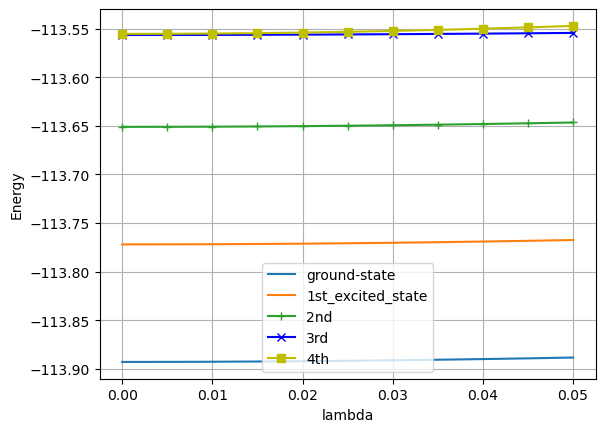

In [21]:
N_el = 100
N_ph = 10
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_10010 = np.zeros((N_l, N_el * N_ph))
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_10010[ctr, :] = instance.PCQED_eigs
    ctr += 1
fast_end = time.time()

print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_10010))

E_pcqed_10010_array = np.array(_pcqed_10010)
E_pcqed_10010_list = E_pcqed_10010_array.tolist()
data_10010 = data

data_10010["model"]["number_of_electronic_states"] = 100
data_10010["model"]["number_of_photonic_states"] = 10
data_10010["return_result"] = E_pcqed_10010_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_10010.json"
json_object = json.dumps(data_10010, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)
    
plt.plot(lambda_val[:,2], _pcqed_10010[:,0], label="ground-state")
plt.plot(lambda_val[:,2],_pcqed_10010[:,1], label='1st_excited_state')
plt.plot(lambda_val[:,2],_pcqed_10010[:,2],marker='+', label='2nd')
plt.plot(lambda_val[:,2],_pcqed_10010[:,3],'b',marker='x', label='3rd')
plt.plot(lambda_val[:,2],_pcqed_10010[:,4],'y',marker='s', label='4th')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.90, -113.85)
plt.grid()
plt.legend()

In [ ]:
N_el = 200
N_ph = 5
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_2005 = np.zeros((N_l, N_el * N_ph))
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_2005[ctr, :] = instance.PCQED_eigs
    ctr += 1
fast_end = time.time()

print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_2005))

E_pcqed_2005_array = np.array(_pcqed_2005)
E_pcqed_2005_list = E_pcqed_2005_array.tolist()
data_2005 = data

data_2005["model"]["number_of_electronic_states"] = 200
data_2005["model"]["number_of_photonic_states"] = 5
data_2005["return_result"] = E_pcqed_2005_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_2005.json"
json_object = json.dumps(data_2005, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)
    
plt.plot(lambda_val[:,2], _pcqed_2005[:,0], label="ground-state")
plt.plot(lambda_val[:,2],_pcqed_2005[:,1], label='1st_excited_state')
plt.plot(lambda_val[:,2],_pcqed_2005[:,2],marker='+', label='2nd')
plt.plot(lambda_val[:,2],_pcqed_2005[:,3],'b',marker='x', label='3rd')
plt.plot(lambda_val[:,2],_pcqed_2005[:,4],'y',marker='s', label='4th')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.90, -113.85)
plt.grid()
plt.legend()

In [ ]:
N_el = 300
N_ph = 5
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_3005 = np.zeros((N_l, N_el * N_ph))
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_3005[ctr, :] = instance.PCQED_eigs
    ctr += 1
fast_end = time.time()

print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_3005))

E_pcqed_3005_array = np.array(_pcqed_3005)
E_pcqed_3005_list = E_pcqed_3005_array.tolist()
data_3005 = data

data_3005["model"]["number_of_electronic_states"] = 300
data_3005["model"]["number_of_photonic_states"] = 5
data_3005["return_result"] = E_pcqed_3005_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_3005.json"
json_object = json.dumps(data_3005, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)
    
plt.plot(lambda_val[:,2], _pcqed_3005[:,0], label="ground-state")
plt.plot(lambda_val[:,2],_pcqed_3005[:,1], label='1st_excited_state')
plt.plot(lambda_val[:,2],_pcqed_3005[:,2],marker='+', label='2nd')
plt.plot(lambda_val[:,2],_pcqed_3005[:,3],'b',marker='x', label='3rd')
plt.plot(lambda_val[:,2],_pcqed_3005[:,4],'y',marker='s', label='4th')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.90, -113.85)
plt.grid()
plt.legend()

In [ ]:
N_el = 400
N_ph = 5
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_4005 = np.zeros((N_l, N_el * N_ph))
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_4005[ctr, :] = instance.PCQED_eigs
    ctr += 1
fast_end = time.time()

print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_4005))

E_pcqed_4005_array = np.array(_pcqed_4005)
E_pcqed_4005_list = E_pcqed_4005_array.tolist()
data_4005 = data

data_4005["model"]["number_of_electronic_states"] = 400
data_4005["model"]["number_of_photonic_states"] = 5
data_4005["return_result"] = E_pcqed_4005_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_4005.json"
json_object = json.dumps(data_4005, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)
    
plt.plot(lambda_val[:,2],_pcqed_4005[:,0], label="ground-state")
plt.plot(lambda_val[:,2],_pcqed_4005[:,1], label='1st_excited_state')
plt.plot(lambda_val[:,2],_pcqed_4005[:,2],marker='+', label='2nd')
plt.plot(lambda_val[:,2],_pcqed_4005[:,3],'b',marker='x', label='3rd')
plt.plot(lambda_val[:,2],_pcqed_4005[:,4],'y',marker='s', label='4th')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.90, -113.85)
plt.grid()
plt.legend()

In [ ]:
N_el = 500
N_ph = 5
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_5005 = np.zeros((N_l, N_el * N_ph))
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_5005[ctr, :] = instance.PCQED_eigs
    ctr += 1
fast_end = time.time()

print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_5005))

E_pcqed_5005_array = np.array(_pcqed_5005)
E_pcqed_5005_list = E_pcqed_5005_array.tolist()
data_5005 = data

data_5005["model"]["number_of_electronic_states"] = 500
data_5005["model"]["number_of_photonic_states"] = 5
data_5005["return_result"] = E_pcqed_5005_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_5005.json"
json_object = json.dumps(data_5005, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)
    
plt.plot(lambda_val[:,2], _pcqed_5005[:,0], label="ground-state")
plt.plot(lambda_val[:,2],_pcqed_5005[:,1], label='1st_excited_state')
plt.plot(lambda_val[:,2],_pcqed_5005[:,2],marker='+', label='2nd')
plt.plot(lambda_val[:,2],_pcqed_5005[:,3],'b',marker='x', label='3rd')
plt.plot(lambda_val[:,2],_pcqed_5005[:,4],'y',marker='s', label='4th')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.90, -113.85)
plt.grid()
plt.legend()

In [ ]:
N_el = 600
N_ph = 5
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_6005 = np.zeros((N_l, N_el * N_ph))
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_6005[ctr, :] = instance.PCQED_eigs
    ctr += 1
fast_end = time.time()

print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_6005))

E_pcqed_6005_array = np.array(_pcqed_6005)
E_pcqed_6005_list = E_pcqed_6005_array.tolist()
data_6005 = data

data_6005["model"]["number_of_electronic_states"] = 600
data_6005["model"]["number_of_photonic_states"] = 5
data_6005["return_result"] = E_pcqed_6005_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_6005.json"
json_object = json.dumps(data_6005, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)
    
plt.plot(lambda_val[:,2], _pcqed_6005[:,0], label="ground-state")
plt.plot(lambda_val[:,2],_pcqed_6005[:,1], label='1st_excited_state')
plt.plot(lambda_val[:,2],_pcqed_6005[:,2],marker='+', label='2nd')
plt.plot(lambda_val[:,2],_pcqed_6005[:,3],'b',marker='x', label='3rd')
plt.plot(lambda_val[:,2],_pcqed_6005[:,4],'y',marker='s', label='4th')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.90, -113.85)
plt.grid()
plt.legend()

In [ ]:
N_el = 700
N_ph = 5
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_7005 = np.zeros((N_l, N_el * N_ph))
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_7005[ctr, :] = instance.PCQED_eigs
    ctr += 1
fast_end = time.time()

print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_7005))

E_pcqed_7005_array = np.array(_pcqed_7005)
E_pcqed_7005_list = E_pcqed_7005_array.tolist()
data_7005 = data

data_7005["model"]["number_of_electronic_states"] = 700
data_7005["model"]["number_of_photonic_states"] = 5
data_7005["return_result"] = E_pcqed_7005_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_7005.json"
json_object = json.dumps(data_7005, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)
    
plt.plot(lambda_val[:,2], _pcqed_7005[:,0], label="ground-state")
plt.plot(lambda_val[:,2],_pcqed_7005[:,1], label='1st_excited_state')
plt.plot(lambda_val[:,2],_pcqed_7005[:,2],marker='+', label='2nd')
plt.plot(lambda_val[:,2],_pcqed_7005[:,3],'b',marker='x', label='3rd')
plt.plot(lambda_val[:,2],_pcqed_7005[:,4],'y',marker='s', label='4th')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.90, -113.85)
plt.grid()
plt.legend()

In [ ]:
N_el = 800
N_ph = 5
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_8005 = np.zeros((N_l, N_el * N_ph))
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_8005[ctr, :] = instance.PCQED_eigs
    ctr += 1
fast_end = time.time()

print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_8005))

E_pcqed_8005_array = np.array(_pcqed_8005)
E_pcqed_8005_list = E_pcqed_8005_array.tolist()
data_8005 = data

data_8005["model"]["number_of_electronic_states"] = 800
data_8005["model"]["number_of_photonic_states"] = 5
data_8005["return_result"] = E_pcqed_8005_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_8005.json"
json_object = json.dumps(data_8005, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)
    
plt.plot(lambda_val[:,2], _pcqed_8005[:,0], label="ground-state")
plt.plot(lambda_val[:,2],_pcqed_8005[:,1], label='1st_excited_state')
plt.plot(lambda_val[:,2],_pcqed_8005[:,2],marker='+', label='2nd')
plt.plot(lambda_val[:,2],_pcqed_8005[:,3],'b',marker='x', label='3rd')
plt.plot(lambda_val[:,2],_pcqed_8005[:,4],'y',marker='s', label='4th')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.90, -113.85)
plt.grid()
plt.legend()

In [ ]:
N_el = 900
N_ph = 5
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_9005 = np.zeros((N_l, N_el * N_ph))
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_9005[ctr, :] = instance.PCQED_eigs
    ctr += 1
fast_end = time.time()

print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_7005))

E_pcqed_9005_array = np.array(_pcqed_7005)
E_pcqed_9005_list = E_pcqed_9005_array.tolist()
data_9005 = data

data_9005["model"]["number_of_electronic_states"] = 900
data_9005["model"]["number_of_photonic_states"] = 5
data_9005["return_result"] = E_pcqed_9005_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_9005.json"
json_object = json.dumps(data_9005, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)
    
plt.plot(lambda_val[:,2],_pcqed_9005[:,0], label="ground-state")
plt.plot(lambda_val[:,2],_pcqed_9005[:,1], label='1st_excited_state')
plt.plot(lambda_val[:,2],_pcqed_9005[:,2],marker='+', label='2nd')
plt.plot(lambda_val[:,2],_pcqed_9005[:,3],'b',marker='x', label='3rd')
plt.plot(lambda_val[:,2],_pcqed_9005[:,4],'y',marker='s', label='4th')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.90, -113.85)
plt.grid()
plt.legend()

In [ ]:
N_el = 1000
N_ph = 2
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_10002 = np.zeros((N_l, N_el * N_ph))
# loop over values of lambda, build Hamiltonian, capture eigenvalues
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_10002[ctr, :] = instance.PCQED_eigs
    ctr += 1

# E_pcqed_52 = instance.PCQED_eigs

fast_end = time.time()
print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_10002))
E_pcqed_10002_array = np.array(_pcqed_10002)
E_pcqed_10002_list = E_pcqed_10002_array.tolist()


In [ ]:
data_10002 = data

data_10002["model"]["number_of_electronic_states"] = 1000
data_10002["model"]["number_of_photonic_states"] = 2
data_10002["return_result"] = E_pcqed_10002_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_10002.json"
json_object = json.dumps(data_10002, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)
    

In [ ]:
plt.plot(lambda_val[:,2], _pcqed_10002[:,0], label="ground-state_1002")
plt.plot(lambda_val[:,2],_pcqed_10002[:,1], label='1st_excited_state_1002')
plt.plot(lambda_val[:,2],_pcqed_10002[:,2],'ro-', label='2nd_10002')
plt.plot(lambda_val[:,2],_pcqed_10002[:,3],color='green', marker='x', label='3rd_1002')
plt.plot(lambda_val[:,2],_pcqed_10002[:,4],'k', marker='p',label='4th')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.90, -113.85)
plt.grid()
plt.legend()

In [ ]:
# N_el = 1000
# N_ph = 5
# omega = 0.12086

# fast_start = time.time()
# # create an array of zeros to store the PCQED eigenvalues for each value of lambda
# _pcqed_10005 = np.zeros((N_l, N_el * N_ph))
# ctr = 0
# for lam in lambdas:
#     instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
#     _pcqed_10005[ctr, :] = instance.PCQED_eigs
#     ctr += 1
# fast_end = time.time()

# print(F"Fast build took {fast_end-fast_start} seconds")
# print(np.shape(_pcqed_10005))

# E_pcqed_10005_array = np.array(_pcqed_10005)
# E_pcqed_10005_list = E_pcqed_10005_array.tolist()
# data_10005 = data

# data_10005["model"]["number_of_electronic_states"] = 1000
# data_10005["model"]["number_of_photonic_states"] = 5
# data_10005["return_result"] = E_pcqed_10005_list
# # print(data_122)
# file_name = "CH2O_CO_r_1.3_pcqed_10005.json"
# json_object = json.dumps(data_10005, indent=4)
# with open(file_name, "w") as outfile:
#     outfile.write(json_object)
    
# plt.plot(lambda_val[:,2], _pcqed_10005[:,0], label="ground-state")
# plt.plot(lambda_val[:,2],_pcqed_10005[:,1], label='1st_excited_state')
# plt.plot(lambda_val[:,2],_pcqed_10005[:,2],marker='+', label='2nd')
# plt.plot(lambda_val[:,2],_pcqed_10005[:,3],'b',marker='x', label='3rd')
# plt.plot(lambda_val[:,2],_pcqed_10005[:,4],'y',marker='s', label='4th')
# plt.xlabel('lambda')
# plt.ylabel('Energy')
# # plt.ylim(-113.90, -113.85)
# plt.grid()
# plt.legend()

In [ ]:
# N_el = 1000
# N_ph = 7
# omega = 0.12086

# fast_start = time.time()
# # create an array of zeros to store the PCQED eigenvalues for each value of lambda
# _pcqed_10007 = np.zeros((N_l, N_el * N_ph))
# ctr = 0
# for lam in lambdas:
#     instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
#     _pcqed_10007[ctr, :] = instance.PCQED_eigs
#     ctr += 1
# fast_end = time.time()

# print(F"Fast build took {fast_end-fast_start} seconds")
# print(np.shape(_pcqed_10007))

# E_pcqed_10007_array = np.array(_pcqed_10007)
# E_pcqed_10007_list = E_pcqed_10007_array.tolist()
# data_10007 = data

# data_10007["model"]["number_of_electronic_states"] = 1000
# data_10007["model"]["number_of_photonic_states"] = 7
# data_10007["return_result"] = E_pcqed_10007_list
# # print(data_122)
# file_name = "CH2O_CO_r_1.3_pcqed_10007.json"
# json_object = json.dumps(data_10007, indent=4)
# with open(file_name, "w") as outfile:
#     outfile.write(json_object)
    
# plt.plot(lambda_val[:,2], _pcqed_10007[:,0], label="ground-state")
# plt.plot(lambda_val[:,2],_pcqed_10007[:,1], label='1st_excited_state')
# plt.plot(lambda_val[:,2],_pcqed_10007[:,2],marker='+', label='2nd')
# plt.plot(lambda_val[:,2],_pcqed_10007[:,3],'b',marker='x', label='3rd')
# plt.plot(lambda_val[:,2],_pcqed_10007[:,4],'y',marker='s', label='4th')
# plt.xlabel('lambda')
# plt.ylabel('Energy')
# # plt.ylim(-113.90, -113.85)
# plt.grid()
# plt.legend()

In [ ]:
N_el = 1000
N_ph = 10
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_100010 = np.zeros((N_l, N_el * N_ph))
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_100010[ctr, :] = instance.PCQED_eigs
    ctr += 1
fast_end = time.time()

print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_100010))

E_pcqed_100010_array = np.array(_pcqed_100010)
E_pcqed_100010_list = E_pcqed_100010_array.tolist()
data_100010 = data

data_100010["model"]["number_of_electronic_states"] = 1000
data_100010["model"]["number_of_photonic_states"] = 10
data_100010["return_result"] = E_pcqed_100010_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_100010.json"
json_object = json.dumps(data_100010, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)
    
plt.plot(lambda_val[:,2], _pcqed_100010[:,0], label="ground-state_502")
plt.plot(lambda_val[:,2],_pcqed_100010[:,1], label='1st_excited_state_502')
plt.plot(lambda_val[:,2],_pcqed_100010[:,2],marker='+', label='2nd_502')
plt.plot(lambda_val[:,2],_pcqed_100010[:,3],'b',marker='x', label='3rd_502')
plt.plot(lambda_val[:,2],_pcqed_100010[:,4],'y',marker='s', label='4th_502')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.90, -113.85)
plt.grid()
plt.legend()

In [ ]:
N_el = 18
N_ph = 5
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_185 = np.zeros((N_l, N_el * N_ph))
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_185[ctr, :] = instance.PCQED_eigs
    ctr += 1
fast_end = time.time()

print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_185))

E_pcqed_185_array = np.array(_pcqed_185)
E_pcqed_185_list = E_pcqed_185_array.tolist()
data_185 = data

data_185["model"]["number_of_electronic_states"] = 18
data_185["model"]["number_of_photonic_states"] = 5
data_185["return_result"] = E_pcqed_185_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_185.json"
json_object = json.dumps(data_185, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)
    
# plt.plot(lambda_val[:,2], _pcqed_210[:,0], label="ground-state_502")
# plt.plot(lambda_val[:,2],_pcqed_210[:,1], label='1st_excited_state_502')
# plt.plot(lambda_val[:,2],_pcqed_210[:,2],marker='+', label='2nd_502')
# plt.plot(lambda_val[:,2],_pcqed_210[:,3],'b',marker='x', label='3rd_502')
# plt.plot(lambda_val[:,2],_pcqed_210[:,4],'y',marker='s', label='4th_502')
# plt.xlabel('lambda')
# plt.ylabel('Energy')
# # plt.ylim(-113.90, -113.85)
# plt.grid()
# plt.legend()

In [ ]:
N_el = 5
N_ph = 2
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_52 = np.zeros((N_l, N_el * N_ph))
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_52[ctr, :] = instance.PCQED_eigs
    ctr += 1
fast_end = time.time()

print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_52))

E_pcqed_52_array = np.array(_pcqed_52)
E_pcqed_52_list = E_pcqed_52_array.tolist()
data_52 = data

data_52["model"]["number_of_electronic_states"] = 5
data_52["model"]["number_of_photonic_states"] = 2
data_52["return_result"] = E_pcqed_52_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_52.json"
json_object = json.dumps(data_52, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)
    
plt.plot(lambda_val[:,2], _pcqed_52[:,0], label="ground-state_502")
plt.plot(lambda_val[:,2],_pcqed_52[:,1], label='1st_excited_state_502')
plt.plot(lambda_val[:,2],_pcqed_52[:,2],marker='+', label='2nd_502')
plt.plot(lambda_val[:,2],_pcqed_52[:,3],'b',marker='x', label='3rd_502')
plt.plot(lambda_val[:,2],_pcqed_52[:,4],'y',marker='s', label='4th_502')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.90, -113.85)
plt.grid()
plt.legend()

In [ ]:
N_el = 10
N_ph = 10
omega = 0.12086

fast_start = time.time()
# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_1010 = np.zeros((N_l, N_el * N_ph))
ctr = 0
for lam in lambdas:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lam, E_array, Mu_array)
    _pcqed_1010[ctr, :] = instance.PCQED_eigs
    ctr += 1
fast_end = time.time()

print(F"Fast build took {fast_end-fast_start} seconds")
print(np.shape(_pcqed_1010))

E_pcqed_1010_array = np.array(_pcqed_1010)
E_pcqed_1010_list = E_pcqed_1010_array.tolist()
data_1010 = data

data_1010["model"]["number_of_electronic_states"] = 10
data_1010["model"]["number_of_photonic_states"] = 10
data_1010["return_result"] = E_pcqed_1010_list
# print(data_122)
file_name = "CH2O_CO_r_1.3_pcqed_1010.json"
json_object = json.dumps(data_1010, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)
    
plt.plot(lambda_val[:,2], _pcqed_1010[:,0], label="ground-state_502")
plt.plot(lambda_val[:,2],_pcqed_1010[:,1], label='1st_excited_state_502')
plt.plot(lambda_val[:,2],_pcqed_1010[:,2],marker='+', label='2nd_502')
plt.plot(lambda_val[:,2],_pcqed_1010[:,3],'b',marker='x', label='3rd_502')
plt.plot(lambda_val[:,2],_pcqed_1010[:,4],'y',marker='s', label='4th_502')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.90, -113.85)
plt.grid()
plt.legend()

In [ ]:
plt.plot(lambda_val[:,2], _pcqed_100010[:,0],'g',marker='s', label="ground-state_100010")
plt.plot(lambda_val[:,2],_pcqed_22[:,0], label='ground-state_22')
plt.plot(lambda_val[:,2],_pcqed_10010[:,0],marker='d', label='ground-state_10010')
plt.plot(lambda_val[:,2],_pcqed_122[:,0],marker='+', label='ground-state_122')
plt.plot(lambda_val[:,2],_pcqed_502[:,0],'b',marker='x', label='ground-state_502')
plt.plot(lambda_val[:,2],_pcqed_52[:,0],'k',marker='s', label='ground-state_52')
plt.plot(lambda_val[:,2],_pcqed_1010[:,0],'m',marker='|', label='ground-state_1010')
plt.plot(lambda_val[:,2],_pcqed_210[:,0],'y',marker='s', label='ground-state_210')
# plt.plot(lambda_val[:,2],_pcqed_185[:,0],'y',marker='s', label='ground-state_210')
plt.xlabel('lambda')
plt.ylabel('Energy')
plt.ylim(-113.905, -113.885)
# plt.grid()
plt.legend()

In [ ]:
plt.plot(lambda_val[:,2], _pcqed_100010[:,1],'g',marker='s', label="1st_excited_state_100010")
plt.plot(lambda_val[:,2],_pcqed_22[:,1], label='1st_excited-state_22')
plt.plot(lambda_val[:,2],_pcqed_10010[:,1],marker='d', label='1st_excited-state_10010')
plt.plot(lambda_val[:,2],_pcqed_122[:,1],marker='+', label='1st_excited-state_122')
plt.plot(lambda_val[:,2],_pcqed_502[:,1],'b',marker='x', label='1st_excited-state_502')
plt.plot(lambda_val[:,2],_pcqed_52[:,1],'k',marker='s', label='1st_excited-state_52')
plt.plot(lambda_val[:,2],_pcqed_1010[:,1],'m',marker='|', label='1st_excited-state_1010')
plt.plot(lambda_val[:,2],_pcqed_210[:,1],'y',marker='s', label='1st_excited-state_210')
# plt.plot(lambda_val[:,2],_pcqed_185[:,0],'y',marker='s', label='ground-state_210')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.905, -113.885)
# plt.grid()
plt.legend()

In [ ]:
plt.plot(lambda_val[:,2], _pcqed_100010[:,2],'g',marker='s', label="2nd_excited_state_100010")
plt.plot(lambda_val[:,2],_pcqed_22[:,2], label='2nd_excited-state_22')
plt.plot(lambda_val[:,2],_pcqed_10010[:,2],marker='d', label='2nd_excited-state_10010')
plt.plot(lambda_val[:,2],_pcqed_122[:,2],marker='+', label='2nd_excited-state_122')
plt.plot(lambda_val[:,2],_pcqed_502[:,2],'b',marker='x', label='2nd_excited-state_502')
plt.plot(lambda_val[:,2],_pcqed_52[:,2],'k',marker='s', label='2nd_excited-state_52')
plt.plot(lambda_val[:,2],_pcqed_1010[:,2],'m',marker='|', label='2nd_excited-state_1010')
plt.plot(lambda_val[:,2],_pcqed_210[:,2],'y',marker='s', label='2nd_excited-state_210')
# plt.plot(lambda_val[:,2],_pcqed_185[:,0],'y',marker='s', label='ground-state_210')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.905, -113.885)
# plt.grid()
plt.legend()

In [ ]:
plt.plot(lambda_val[:,2], _pcqed_100010[:,4],'g',marker='s', label="4th_excited_state_100010")
# plt.plot(lambda_val[:,2],_pcqed_22[:,4], label='3rd_excited-state_22')
plt.plot(lambda_val[:,2],_pcqed_10010[:,4],marker='d', label='4th_excited-state_10010')
plt.plot(lambda_val[:,2],_pcqed_122[:,4],marker='+', label='4th_excited-state_122')
plt.plot(lambda_val[:,2],_pcqed_502[:,4],'b',marker='x', label='4th_excited-state_502')
plt.plot(lambda_val[:,2],_pcqed_52[:,4],'k',marker='s', label='4th_excited-state_52')
plt.plot(lambda_val[:,2],_pcqed_1010[:,4],'m',marker='|', label='4th_excited-state_1010')
plt.plot(lambda_val[:,2],_pcqed_210[:,4],'y',marker='s', label='4th_excited-state_210')
# plt.plot(lambda_val[:,2],_pcqed_185[:,0],'y',marker='s', label='ground-state_210')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-113.905, -113.885)
# plt.grid()
plt.legend()

In [ ]:
plt.plot(lambda_val[:,2], _pcqed_100010[:,0],'g',marker='s', label="ground-state_100010")
plt.plot(lambda_val[:,2],_pcqed_22[:,0], label='ground-state_22')
plt.plot(lambda_val[:,2],_pcqed_10010[:,0],marker='d', label='ground-state_10010')
plt.plot(lambda_val[:,2],_pcqed_122[:,0],marker='+', label='ground-state_122')
plt.plot(lambda_val[:,2],_pcqed_502[:,0],'b',marker='x', label='ground-state_502')
plt.plot(lambda_val[:,2],_pcqed_52[:,0],'k',marker='s', label='ground-state_52')
plt.plot(lambda_val[:,2],_pcqed_1010[:,0],'m',marker='|', label='ground-state_1010')
plt.plot(lambda_val[:,2],_pcqed_210[:,0],'y',marker='s', label='ground-state_210')
plt.plot(lambda_val[:,2], _pcqed_100010[:,1],'g',marker='s', label="1st_excited_state_100010")
plt.plot(lambda_val[:,2],_pcqed_22[:,1], label='1st_excited-state_22')
plt.plot(lambda_val[:,2],_pcqed_10010[:,1],marker='d', label='1st_excited-state_10010')
plt.plot(lambda_val[:,2],_pcqed_122[:,1],marker='+', label='1st_excited-state_122')
plt.plot(lambda_val[:,2],_pcqed_502[:,1],'b',marker='x', label='1st_excited-state_502')
plt.plot(lambda_val[:,2],_pcqed_52[:,1],'k',marker='s', label='1st_excited-state_52')
plt.plot(lambda_val[:,2],_pcqed_1010[:,1],'m',marker='|', label='1st_excited-state_1010')
plt.plot(lambda_val[:,2], _pcqed_100010[:,2],'g',marker='s', label="2nd_excited_state_100010")
plt.plot(lambda_val[:,2],_pcqed_22[:,2], label='2nd_excited-state_22')
plt.plot(lambda_val[:,2],_pcqed_10010[:,2],marker='d', label='2nd_excited-state_10010')
plt.plot(lambda_val[:,2],_pcqed_122[:,2],marker='+', label='2nd_excited-state_122')
plt.plot(lambda_val[:,2],_pcqed_502[:,2],'b',marker='x', label='2nd_excited-state_502')
plt.plot(lambda_val[:,2],_pcqed_52[:,2],'k',marker='s', label='2nd_excited-state_52')
plt.plot(lambda_val[:,2],_pcqed_1010[:,2],'m',marker='|', label='2nd_excited-state_1010')
plt.plot(lambda_val[:,2],_pcqed_210[:,2],'y',marker='s', label='2nd_excited-state_210')
plt.plot(lambda_val[:,2], _pcqed_100010[:,3],'g',marker='s', label="3rd_excited_state_100010")
plt.plot(lambda_val[:,2],_pcqed_22[:,3], label='3rd_excited-state_22')
plt.plot(lambda_val[:,2],_pcqed_10010[:,3],marker='d', label='3rd_excited-state_10010')
plt.plot(lambda_val[:,2],_pcqed_122[:,3],marker='+', label='3rd_excited-state_122')
plt.plot(lambda_val[:,2],_pcqed_502[:,3],'b',marker='x', label='3rd_excited-state_502')
plt.plot(lambda_val[:,2],_pcqed_52[:,3],'k',marker='s', label='3rd_excited-state_52')
plt.plot(lambda_val[:,2],_pcqed_1010[:,3],'m',marker='|', label='3rd_excited-state_1010')
plt.plot(lambda_val[:,2],_pcqed_210[:,3],'y',marker='s', label='3rd_excited-state_210')
plt.plot(lambda_val[:,2], _pcqed_100010[:,4],'g',marker='s', label="4th_excited_state_100010")
# plt.plot(lambda_val[:,2],_pcqed_22[:,4], label='3rd_excited-state_22')
plt.plot(lambda_val[:,2],_pcqed_10010[:,4],marker='d', label='4th_excited-state_10010')
plt.plot(lambda_val[:,2],_pcqed_122[:,4],marker='+', label='4th_excited-state_122')
plt.plot(lambda_val[:,2],_pcqed_502[:,4],'b',marker='x', label='4th_excited-state_502')
plt.plot(lambda_val[:,2],_pcqed_52[:,4],'k',marker='s', label='4th_excited-state_52')
plt.plot(lambda_val[:,2],_pcqed_1010[:,4],'m',marker='|', label='4th_excited-state_1010')
plt.plot(lambda_val[:,2],_pcqed_210[:,4],'y',marker='s', label='4th_excited-state_210')
# plt.plot(lambda_val[:,2],_pcqed_185[:,0],'y',marker='s', label='ground-state_210')
plt.xlabel('lambda')
plt.ylabel('Energy')
plt.rcParams["figure.figsize"] = (15, 20)
# plt.ylim(-113.905, -113.885)
# plt.grid()
plt.legend()

# Notes on the matrix blocks

\begin{align}\label{EQN:projected_matrix}
{\bf \mathcal{H}} =
&\begin{bmatrix}
{\bf E} + {\bf D}   & -\sqrt{\frac{\omega}{2}} {\bf d}  & 0 & \dots & 0 & 0 \\
-\sqrt{\frac{\omega}{2}}{\bf d} & {\bf E} + {\bf D} + {\bf \Omega}   & -\sqrt{\omega} {\bf d}  & \dots & 0 & 0 \\
0   &  -\sqrt{\omega}{\bf d} & {\bf E} + {\bf D} + 2{\bf \Omega} & \dots & 0  & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0      &      0 &   0    &  \dots     & {\bf E} + {\bf D} + (N-1){\bf \Omega}    & -\sqrt{\frac{N \omega}{2}} {\bf d} \\
0      &      0 &   0    &  \dots     & -\sqrt{\frac{N \omega}{2}}{\bf d}     & {\bf E} + {\bf D} + N{\bf \Omega}. 
\end{bmatrix}
\end{align}


Note that there are basically 4 different matrices with shape $(N_{el}, N_{el})$ that appear in this Hamiltonian matrix.  The following outlines the equations for the elements of each matrix along with one or more strategies to assemble them.  

### E matrix
#### Math
$$ E_{\alpha \beta} = \langle \psi_{\alpha} | \mathcal{H}_{el} | \psi_{\beta} \rangle = E_{\beta} \delta_{\alpha \beta} $$ 
where $E_{\beta}$ denote the electronic energy eigenvalues of the molecular system.
#### Code
If the energy eigenvalues are stored in an array called `E_array`, then we can build ${\bf E}$ by multiplying these values by an $(N_{el}, N_{el})$ identity matrix $\mathbb{I}$.

##### build N_el x N_el identity matrix
`_I = np.eye(N_el)`

##### build N_el x N_el _E matrix
`_E = E_array * _I`




In [ ]:
# code to build E matrix goes here
_I = np.eye(N_el)
_A = E_array[:N_el] * _I

### $\Omega$ matrix
#### Math
$$ \Omega_{\alpha \beta} = \langle \psi_{\alpha} | \omega | \psi_{\beta} \rangle  = \omega \delta_{\alpha \beta}$$ 

#### Code
If the photon frequency is stored in the variable `omega`, then the $(N_{el},N_{el})$ matrix `_O` can be build 
by multiplying the $\mathbb{I}$ by $omega$:

##### build N_el x N_el _O matrix
`_O = omega * _I`


In [ ]:
# code to build Omega matrix goes here
_O = omega * _I

### d matrix
#### Math
$$ d_{\alpha \beta} = \lambda \cdot  \langle \psi_{\alpha} | \mathcal{\mu} | \psi_{\beta} \rangle = \lambda_x \mathcal{\mu}_{x, \alpha \beta} +  \lambda_y \mathcal{\mu}_{y, \alpha \beta} +  \lambda_z \mathcal{\mu}_{z, \alpha \beta} $$ 
where $\mathcal{\mu}_{x, \alpha \beta}$ denotes the x-component of the (transition) dipole moment between molecular electronic state $\psi_{\alpha}$ and $\psi_{\beta}$.
#### Code
If the dipole matrix elements are stored in a $(N_{el}, N_{el}, 3)$  array called `mu_array` and the $\lambda$ vector is stored in an 3-element array called `\lambda_vector`, then we can build the
$(N_{el}, N_{el})$ array ${\bf d}$ by [contraction](https://en.wikipedia.org/wiki/Tensor_contraction) using `np.einsum()`:

##### build N_el x N_el _d matrix
`_d = np.einsum("k,ijk->ij", lambda_vector, mu_array)`

In [ ]:
# code to build the d matrix goes here
_d = np.einsum("k,ijk->ij", lambda_vector, Mu_array)

### D matrix
#### Math
$$ D_{\alpha \beta} = \frac{1}{2} \sum_{\gamma} d_{\alpha \gamma} d_{\gamma \beta} $$ 

#### Code
We have the $(N_{el}, N_{el})$ elements of the ${\bf d}$ array stored in `_d`.  We can then build `_D`
using matrix-matrix multiplication as follows:

`_D = _d @ _d`

or using einsum as follows:

`_D = np.einsum("ik,kj->ij",_d, _d)`


In [ ]:
# code to build the D matrix goes here
_D = _d @ _d
# _D = np.einsum("ik,kj->ij",_d, _d)